In [25]:

import time
# Get current Unix timestamp as an integer
current_unix_timestamp = int(time.time())
print(current_unix_timestamp)

1759761430


In [ ]:
import requests
import json
import os

task_path = "week_11_new/shreyansh_pod/swayam_lodha-fund_finance-2-medium-1759745326/task.json"

with open(task_path, 'r') as file:
    task_json = json.load(file)

# Add the task file name to the request so the server can include it in the filename
task_json['task_file_name'] = task_path

# Configure number of trials/retries for task execution
# Default is 1, but you can increase for more robust results
task_json['num_trials'] = 1  # Change this to desired number of trials

API_BASE_URL= "https://tau-bench.turing.com"
# API_BASE_URL= "http://localhost:8000"

# Choose which endpoint to use
endpoint_options = {
    "compute_complexity": f"{API_BASE_URL}/compute_complexity",
    "task_verification": f"{API_BASE_URL}/task_verification", 
    "run_task": f"{API_BASE_URL}/run-task",
    "evaluate": f"{API_BASE_URL}/evaluate"
}

# Select the endpoint you want to use
selected_endpoint = "run_task"  # Change this to "compute_complexity", "task_verification", "run_task", or "evaluate" as needed
endpoint_url = endpoint_options[selected_endpoint]

print(f"Using endpoint: {endpoint_url}")

# Handle different request payloads based on endpoint
if selected_endpoint == "evaluate":
    # For error evaluation, we need to specify results file path or results data
    # Look for result.json in the same directory as the task file
    task_dir = os.path.dirname(task_path)
    results_file_path = os.path.join(task_dir, "result.json")
    
    # Read the results data from file (since Docker container can't access host files)
    if os.path.exists(results_file_path):
        with open(results_file_path, 'r') as f:
            results_data = json.load(f)
        print(f"Loaded results data from: {results_file_path}")
        print(f"Results contain {len(results_data)} entries")
        
        # Let's peek at the structure to see if there are failures
        if results_data:
            sample_result = results_data[0] if isinstance(results_data, list) else results_data
            print(f"Sample result keys: {list(sample_result.keys()) if isinstance(sample_result, dict) else 'Not a dict'}")
            
    else:
        print(f"Results file not found: {results_file_path}")
        print("Available result files in task directory:")
        task_dir = os.path.dirname(task_path)
        if os.path.exists(task_dir):
            for file in os.listdir(task_dir):
                if file.endswith('.json'):
                    print(f"  - {file}")
        results_data = None
    
    # Create error evaluation request payload - send data inline instead of file path
    if results_data is not None:
        error_eval_payload = {
            "env": "fund_finance",  # Changed to match the results file environment
            "model_provider": "openai",
            "model": "gpt-4o",
            "max_concurrency": 1,
            "max_num_failed_results": 10,  # Limit analysis to first 10 failed results
            "results_data": results_data,  # Send data inline instead of file path
            "task_file_name": task_path
        }
        request_payload = error_eval_payload
        print(f"Prepared error evaluation request with inline data")
    else:
        print("Cannot proceed without results data")
        request_payload = None
else:
    # For other endpoints, use the original task JSON
    request_payload = task_json
    if selected_endpoint == "run_task":
        print(f"Number of trials: {task_json['num_trials']}")

# Make the API request
if request_payload:
    response = requests.post(
        endpoint_url,
        json=request_payload,
        headers={"Content-Type": "application/json"}
    )
    
    # Handle different response types based on endpoint
    if selected_endpoint == "run_task" and response.status_code == 200:
        # For run-task endpoint, save the downloaded file
        
        # Save in the same directory as the task file
        task_dir = os.path.dirname(task_path)
        os.makedirs(task_dir, exist_ok=True)
        
        # Extract filename from Content-Disposition header if available
        content_disposition = response.headers.get('Content-Disposition', '')
        if 'filename=' in content_disposition:
            original_filename = content_disposition.split('filename=')[1].strip('"')
        else:
            original_filename = None
        
        # Use the filename from the server's Content-Disposition header if available
        if original_filename:
            filename = original_filename
        else:
            # Use standard filename
            filename = "result.json"
        
        # Save the raw file first
        raw_file_path = os.path.join(task_dir, "result.json")
        with open(raw_file_path, 'wb') as f:
            f.write(response.content)
        
        # Load and display the JSON content as-is (no transformation)
        try:
            with open(raw_file_path, 'r') as f:
                response_data = json.load(f)
                print("Response JSON loaded successfully")
                    
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
            with open(raw_file_path, 'r') as f:
                print("First 500 characters of response:")
                print(repr(f.read(500)))
            response_data = None
            
    else:
        # For other endpoints, handle as JSON response
        try:
            response_data = response.json()
            print("JSON response received")
        except json.JSONDecodeError:
            print("Error: Response is not valid JSON")
            print("Response content:", response.text[:500])  # Show first 500 chars
            response_data = None
else:
    response_data = None
    print("No request was made due to missing configuration.")

Using endpoint: https://tau-bench.turing.com/task_verification
JSON response received


In [27]:
# Display the raw response data exactly as received
if response_data is not None:
    if selected_endpoint == "evaluate":
        # Special handling for error evaluation responses
        if response_data.get("success"):
            summary = response_data.get("summary", {})
            print(f"\nSummary:")
            print(f"  Total results: {summary.get('total_results', 0)}")
            print(f"  Failed results: {summary.get('failed_results', 0)}")
            print(f"  Analyzed results: {summary.get('analyzed_results', 0)}")
            
            fault_dist = summary.get("fault_distribution", {})
            if fault_dist:
                print(f"\nFault Distribution:")
                for fault_type, data in fault_dist.items():
                    print(f"  {fault_type.capitalize()}: {data.get('count', 0)} ({data.get('percentage', 0)}%)")
            
            fault_type_dist = summary.get("fault_type_distribution", {})
            if fault_type_dist:
                print(f"\nFault Type Distribution (Agent-caused failures only):")
                for fault_type, data in fault_type_dist.items():
                    print(f"  {fault_type.replace('_', ' ').title()}: {data.get('count', 0)} ({data.get('percentage', 0)}%)")
            
            # Detailed error identification responses - the actual LLM explanations
            fault_assignment = response_data.get("fault_assignment_analysis", [])
            fault_type_analysis = response_data.get("fault_type_analysis", [])
            
            if fault_assignment or fault_type_analysis:
                print("\n" + "=" * 80)
                print("DETAILED ERROR IDENTIFICATION RESPONSES")
                print("=" * 80)
                
                if fault_assignment:
                    print(f"\n🔍 FAULT ASSIGNMENT ANALYSIS ({len(fault_assignment)} failures analyzed)")
                    print("-" * 60)
                    for i, result in enumerate(fault_assignment, 1):
                        task_id = result.get('task_id')
                        author = result.get('author', 'unknown')
                        description = result.get('description', 'No description available')
                        
                        print(f"\n[{i}] Task {task_id}: {author.upper()} FAULT")
                        print(f"    Explanation: {description}")
                
                if fault_type_analysis:
                    print(f"\n🔧 FAULT TYPE ANALYSIS ({len(fault_type_analysis)} agent-caused failures analyzed)")
                    print("-" * 60)
                    for i, result in enumerate(fault_type_analysis, 1):
                        task_id = result.get('task_id')
                        fault_type = result.get('fault_type', 'unknown')
                        description = result.get('description', 'No description available')
                        
                        print(f"\n[{i}] Task {task_id}: {fault_type.replace('_', ' ').upper()}")
                        print(f"    Explanation: {description}")
            else:
                print("\nℹ️  No failed results found in the data to analyze.")
                print("   Possible reasons:")
                print("   1. The results file contains only successful task executions (reward = 1)")
                print("   2. The environment tasks are not available for comparison")
                print("   3. Task ID matching failed")
                print("   To see error identification in action, you need results with failed tasks (reward = 0)")
                print("   and matching environment task definitions.")
                
        else:
            error_msg = response_data.get('error', 'Unknown error')
            print(f"❌ Error evaluation failed: {error_msg}")
    else:
        # For other endpoints, show raw JSON
        print(json.dumps(response_data, indent=2))
        
else:
    print("No response data available")

{
  "success": true,
  "plot_base64": "iVBORw0KGgoAAAANSUhEUgAALOoAAA5KCAYAAABpMa7tAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nOzOQQ3DABADsDX8mRbEFcQekSIbgZ+7ux8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPznTXsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCGtAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGxIOwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwIa0AwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbEg7AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAhrQDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABsSDsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCGtAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGxIOwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwIa0AwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbEg7AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAhrQDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABsSDsAAAAAAAAAAAAAAAAAAAAAA

Legacy results directory does not exist

No result.json found in task directory: week_11_new/shreyansh_pod/swayam_lodha-fund_finance-2-medium-1759745326


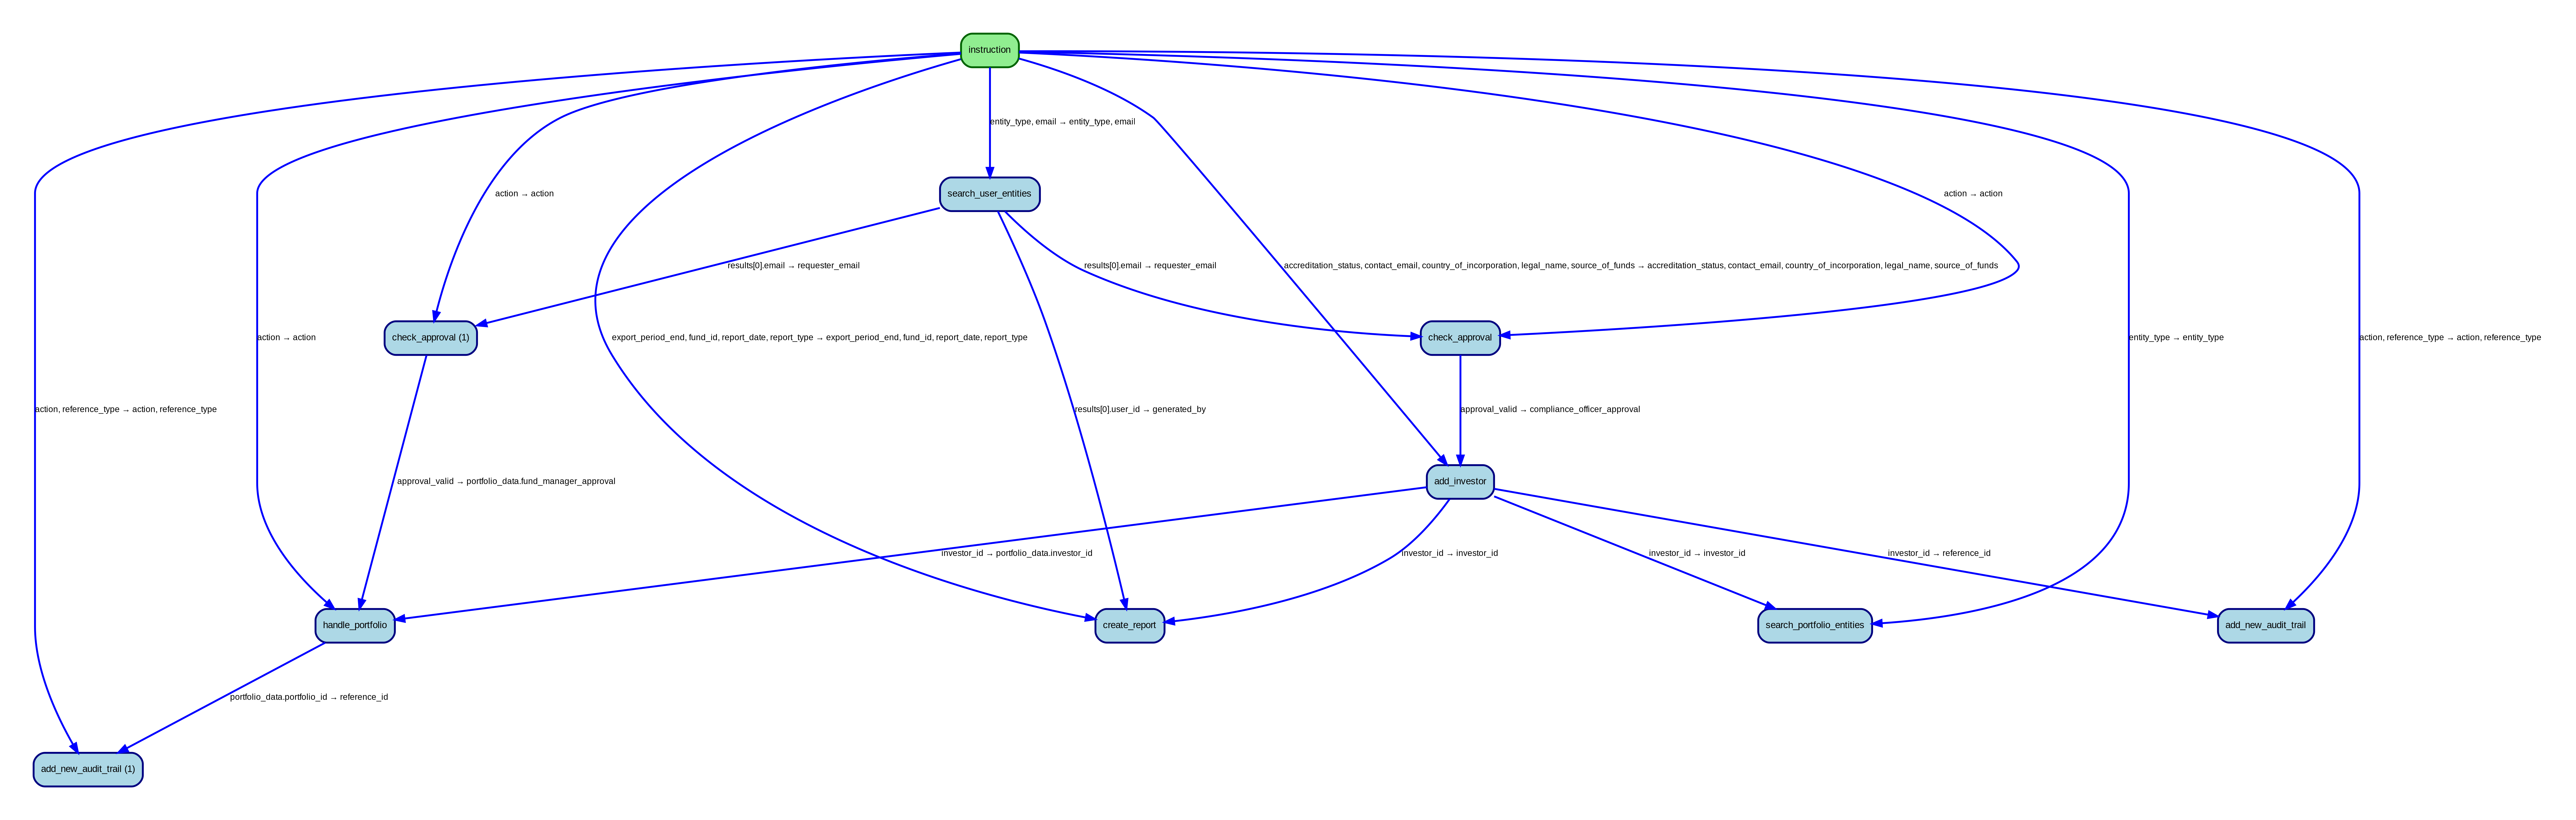

In [28]:
results_dir = "results"
if os.path.exists(results_dir):
    files = os.listdir(results_dir)
    if files:
        print("Legacy results directory:")
        for file in sorted(files):
            file_path = os.path.join(results_dir, file)
            file_size = os.path.getsize(file_path)
            print(f"  - {file} ({file_size} bytes)")
    else:
        print("No files found in legacy results directory")
else:
    print("Legacy results directory does not exist")

# Also check for result.json in the task directory
task_dir = os.path.dirname(task_path) if 'task_path' in globals() else "example"
task_result_file = os.path.join(task_dir, "result.json")
if os.path.exists(task_result_file):
    file_size = os.path.getsize(task_result_file)
    print(f"\nTask result file: {task_result_file} ({file_size} bytes)")
else:
    print(f"\nNo result.json found in task directory: {task_dir}")

# Check if we have response_data from the previous cell
if 'response_data' in globals() and response_data is not None:
    
    # For compute_complexity and task_verification endpoints - look for plots
    if selected_endpoint in ["compute_complexity", "task_verification"]:
        if isinstance(response_data, dict) and 'plot_base64' in response_data and response_data['plot_base64'] is not None:
            from IPython.display import Image, display
            import base64
            
            plot_base64 = response_data['plot_base64']
            plot_image = base64.b64decode(plot_base64)
            display(Image(data=plot_image))
        else:
            print("No plot data found in response")
    
    # For run_task endpoint - show raw structure
    elif selected_endpoint == "run_task":
        print("Raw API response structure displayed above")
    
    # For evaluate endpoint - show detailed analysis
    elif selected_endpoint == "evaluate":
        print("=== DETAILED ERROR ANALYSIS ===")
        if response_data.get("success"):
            fault_assignment = response_data.get("fault_assignment_analysis", [])
            fault_type_analysis = response_data.get("fault_type_analysis", [])
            
            if fault_assignment:
                print(f"\n=== ALL FAULT ASSIGNMENTS ({len(fault_assignment)} total) ===")
                for result in fault_assignment:
                    print(f"Task {result.get('task_id')}: {result.get('author')} fault")
                    print(f"  Description: {result.get('description')}")
                    print()
            
            if fault_type_analysis:
                print(f"\n=== ALL FAULT TYPES ({len(fault_type_analysis)} total) ===")
                for result in fault_type_analysis:
                    print(f"Task {result.get('task_id')}: {result.get('fault_type')}")
                    print(f"  Description: {result.get('description')}")
                    print()
            
            # Create a simple visualization of fault distribution
            summary = response_data.get("summary", {})
            fault_dist = summary.get("fault_distribution", {})
            if fault_dist:
                print("=== FAULT DISTRIBUTION CHART ===")
                max_count = max([data.get('count', 0) for data in fault_dist.values()]) if fault_dist else 1
                for fault_type, data in fault_dist.items():
                    count = data.get('count', 0)
                    percentage = data.get('percentage', 0)
                    bar_length = int((count / max_count) * 20) if max_count > 0 else 0
                    bar = "█" * bar_length + "░" * (20 - bar_length)
                    print(f"{fault_type.capitalize():12} |{bar}| {count:3d} ({percentage:5.1f}%)")
        else:
            print(f"Error in analysis: {response_data.get('error', 'Unknown error')}")
            
else:
    print("No response data available from previous cell")
    print("Please run the previous cells first")